In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from shapely.geometry import Polygon
from tqdm import tqdm

In [2]:
def ret_supp(point, ret_vals):
    
    if point[0] == 0:
        m = 0
    else:
        m = -math.pow(point[1]/point[0],-1)
    #print(m)
    b = point[1] + -m*point[0]
   # print(b)
    #print(f'y = {m}x + {b}')
    x = np.arange(-3,3,.01)
    y = m*x + b
    if ret_vals:
        return m, b
    else:
        return x, y

In [3]:
def ret_int(m1, b1, m2, b2):
    xi = (b1-b2) / (m2-m1)
    yi = m1 * xi + b1

    return xi, yi

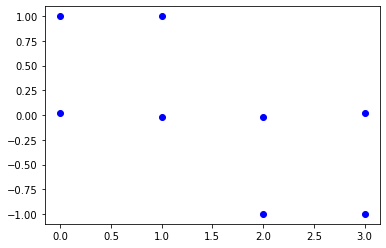

[[-0.26351035  0.5308732  -0.11068126  0.40757173  0.37679599  0.15434658
  -0.29057827  0.44911863  0.0600131   0.18334113 -0.25361553  0.14616528
  -0.3906373  -0.79113857 -0.77995019  0.99287284 -0.29716572 -0.21770617
  -0.39200261  0.94257358  0.13537056  0.71356322 -0.605067   -0.93826043
   0.5950529   0.43379577 -0.70756749  0.11846055  0.02877112  0.70308203
  -0.04158551 -0.10531187 -0.78256589 -0.54828516 -0.85688105 -0.80849661
   0.68799182  0.05058571 -0.57450252  0.15958374 -0.75758416  0.69258557
  -0.33201794 -0.32482165  0.76292873  0.45201709  0.90316047 -0.50559834
   0.94641178 -0.50719121 -0.73575542  0.64496641 -0.55564291 -0.31734338
  -0.95506483 -0.94477483 -0.79403229  0.86316585  0.27670491  0.53044453
   0.4596984  -0.44284526  0.52274548  0.21651247 -0.73127076  0.242844
  -0.97782545 -0.260257   -0.424327    0.82582839  0.20522193 -0.85940908
   0.86171894  0.29144579  0.62558511  0.23769434  0.48084318 -0.44602742
  -0.90461487  0.67474878  0.41831726 -0

In [93]:
n = 103
error = []
eps = 1
#print(eps)
U_x = np.random.uniform(-1,1,(1,n))
U_y = np.random.uniform(-1,1,(1,n))
U = np.vstack((U_x,U_y))
thetas = [0.02, 90, 180, 270]
thetas = [thetas[i] + eps for i in range(4)]
directions = [[np.cos(np.radians(thetas[i])), np.sin(np.radians(thetas[i]))] for i in range(4)]
plt.plot(directions, "bo")
plt.show()
colors = np.array([[np.dot(U[:,i], directions[j]) for i in range(n)] for j in range(4)])
print(colors)
scales = [np.dot(U[:,np.argmax(colors[i])], directions[i]) for i in range(4)]
#print(scales)
supports = np.array([ret_supp([directions[i][0]*scales[i], directions[i][1]*scales[i]], False) for i in range(4)])
#m_b = np.array([ret_supp([directions[i][0]*scales[i], directions[i][1]*scales[i]], True) for i in range(4)])
m_b = np.array([ret_supp([directions[i][0]*scales[i], directions[i][1]*scales[i]], True) for i in range(4)])
print(supports)
print(m_b)

points_of_i = []
for i in range(4):
    if i < 3:
        points_of_i.append(ret_int(m_b[i][0], m_b[i][1], m_b[i+1][0], m_b[i+1][1]))
    else:
        points_of_i.append(ret_int(m_b[i][0], m_b[i][1], m_b[0][0], m_b[0][1]))
#print(points_of_i)
pgon = Polygon(points_of_i) # Assuming the OP's x,y coordinates
error.append(pgon.area)

# plt.xlim([-2,2])
# plt.ylim([-2,2])
# plt.scatter(U[0,:], U[1,:], c=colors[0], cmap="RdYlGn", s=40, edgecolors="black");
# #plt.plot([0,directions[0][0]*(scales[0]+2)], [0, directions[0][1]*(scales[0]+2)], "k", linewidth=4)

# for i in range(4):
#     plt.plot(supports[i][0], supports[i][1], "k", linewidth=4)
# for i in range(len(points_of_i)):
#     plt.plot(points_of_i[i][0],points_of_i[i][1], "rs")
# plt.colorbar()
# plt.show()


In [4]:
def support(X, val, q): # Set q to be the qth quantile
    return np.quantile((X.T).dot(val), q)

def compute_fb(X, q, n):
    polar_body = np.ones((n,0))
    for i in range(X.shape[1]):
        if support(X, X[:,i] / la.norm(X[:,i]), q) > np.dot(X[:,i], X[:,i]/la.norm(X[:,i])): 
            polar_body = np.hstack((polar_body, np.array(X[:,i]).reshape(n,1)))
    return polar_body

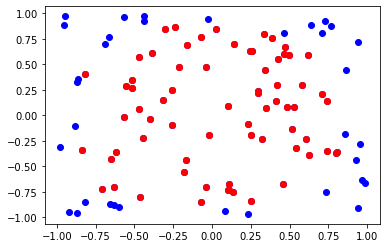

In [18]:
test = np.random.uniform(-1,1,(2, 103))
test_fb = compute_fb(test, .95, 2)
plt.plot(test[0,:], test[1,:], "bo")
plt.plot(test_fb[0,:], test_fb[1,:], "ro")
plt.show()

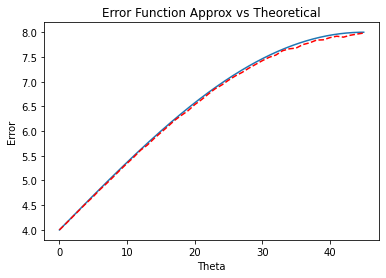

In [69]:
plt.plot([x for x in np.arange(0, 45, .01)], [8*np.sin(np.radians(90+x))*np.sin(np.radians(x))+4 for x in np.arange(0, 45, .01)])
plt.plot([x for x in np.arange(0, 46, 1)], error, 'r--')
plt.xlabel("Theta")
plt.ylabel("Error")
plt.title("Error Function Approx vs Theoretical")
plt.savefig("ErrorApprox.png")

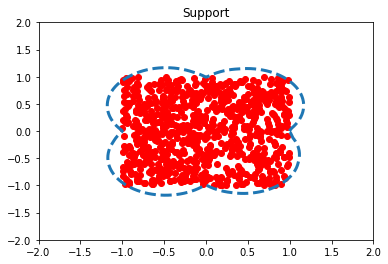

In [19]:
n = 800
U_x = np.random.uniform(-1,1,(1,n))
U_y = np.random.uniform(-1,1,(1,n))
U = np.vstack((U_x,U_y))
support_x = []
support_y = []
for theta in range(0, 361):
    direction = np.array([np.cos(np.radians(theta)), np.sin(np.radians(theta))])
    colors = [np.dot(U[:,i], direction) for i in range(n)]
    scale = np.dot(U[:,np.argmax(colors)], direction)
    support_x.append(direction[0]*scale)
    support_y.append(direction[1]*scale)
support = np.vstack((support_x, support_y))
plt.title(f"Support")
plt.xlim([-2,2])
plt.ylim([-2,2])
plt.scatter(U[0,:], U[1,:], c="red");
plt.plot(support[0,:], support[1,:], "--", linewidth=3)
plt.show()

In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.linalg as la

In [17]:
pi0 = folder['pi0']
mu0 = folder['mu0']
sigma0 = folder['sigma0']

print(f'Check the shape of pi0 = ({pi0.shape}), mu0 = ({mu0.shape}), sigma0 = ({sigma0.shape})')
print(f'pi0: \n{pi0} \n mu0: \n{mu0}\n sigma0: \n{sigma0}')

Check the shape of pi0 = ((3,)), mu0 = ((3, 2)), sigma0 = ((3, 2, 2))
pi0: 
[0.3451814  0.6066179  0.04820071] 
 mu0: 
[[-0.71336192  0.90635089]
 [ 0.76623673  0.82605407]
 [-1.32368279 -1.75244452]]
 sigma0: 
[[[ 1.00490413  1.89980228]
  [ 1.89980228  4.18354574]]

 [[ 1.96867815  0.78415336]
  [ 0.78415336  1.83319942]]

 [[ 0.19316335 -0.11648642]
  [-0.11648642  1.98395967]]]


In [12]:
from scipy.stats import multivariate_normal

def E_step(data, pi, mu, sigma):
    N = data.shape[0]
    K = pi.shape[0]
    d = mu.shape[0]
    gamma = np.zeros((N,K))
    for nk in range(K):
        gamma[:, nk] = pi[nk] * multivariate_normal.pdf(data, mean=mu[nk], cov=sigma[nk])
    gamma = gamma/np.sum(gamma, axis=1, keepdims=True)
    
    return gamma

In [13]:
def M_step(data, gamma):
    N, D = data.shape
    K = gamma.shape[1]
    pi = np.zeros(K)
    mu = np.zeros((K,D))
    sigma = np.zeros((K, D, D))
    
    for ik in range(K):
        n_k = gamma[:, ik].sum()
        pi[ik] = n_k/N
        elements = np.reshape(gamma[:, ik], (gamma.shape[0], 1))
        mu[ik, :] = (np.multiply(elements, data)).sum(axis=0) / n_k
        sigma_sum = 0
        for i in range(N):
            var = data[i] - mu[ik]
            sigma_sum = sigma_sum + gamma[i, ik] * np.outer(var, var)
        sigma[ik, :] = sigma_sum/n_k
    return pi, mu, sigma

In [14]:
def elbo(data, gamma, pi, mu, sigma):
    N = data.shape[0]
    K = gamma.shape[1]
    d = data.shape[1]
    
    loss = 0
    for i in range(N):
        x = data[i]
        for k in range(K):
            pos_dist = gamma[i, k]
            log_lik = np.log(multivariate_normal.pdf(x, mean=mu[k, :], cov=sigma[k, :, :] + 1e-20))
            log_q = np.log(gamma[i, k] + 1e-20)
            log_pz = np.log(pi[k] + 1e-20)
            loss = (loss + np.multiply(pos_dist, log_pz) + np.multiply(pos_dist, log_lik) + np.multiply(pos_dist, -log_q))
    return loss

In [15]:
def train_loop(data, K, tolerance=1e-9, max_iter=50,restart=10):
    N, d = data.shape
    elbo_best = -np.inf
    pi_best = None
    mu_best = None
    sigma_best = None
    gamma_f = None
    for _ in range(restart):
        pi = np.ones(K) / K
        mu = np.random.rand(K, d)
        sigma = np.tile(np.eye(d), (K, 1, 1))
        last_iter_loss = None
        all_losses = []
        try: 
            
            for i in range(max_iter):
                gamma = E_step(data, pi, mu, sigma)
                pi, mu, sigma = M_step(data, gamma)
                loss = elbo(data, gamma, pi, mu, sigma)
                if loss > elbo_best:
                    elbo_best = loss
                    pi_best = pi
                    mu_best = mu
                    sigma_best = sigma
                    gamma_f = gamma
                if last_iter_loss and abs((loss - last_iter_loss)/last_iter_loss) < tolerance:
                    break
                last_iter_loss = loss
                all_losses.append(loss)
        except np.linalg.LinAlgError:
            pass
    return elbo_best, pi_best, mu_best, sigma_best, all_losses, gamma_f

In [83]:
best_loss, pi_best, mu_best, sigma_best, ls_lst, final_posterior = train_loop(data, 3)

In [84]:
print ("starting loss, best_loss: ", ls_lst[0], ',',  best_loss)
print ("best pi", pi_best) 
print ("best mu: ", mu_best)

print ("best sigma: ", sigma_best)

starting loss, best_loss:  -1210.7762035426958 , -1063.8112565703846
best pi [0.55082342 0.10730976 0.34186682]
best mu:  [[1.22309493 5.83019484]
 [6.29623091 4.43088254]
 [0.92114773 0.96659099]]
best sigma:  [[[ 0.9435235   0.0673393 ]
  [ 0.0673393   1.10641904]]

 [[ 1.70899045  1.39173436]
  [ 1.39173436  1.32294102]]

 [[ 1.49892434 -0.37295443]
  [-0.37295443  1.42888142]]]


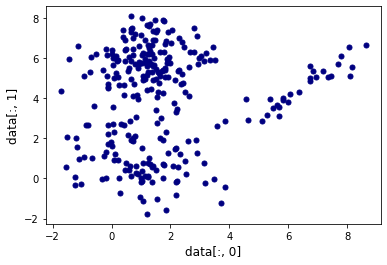

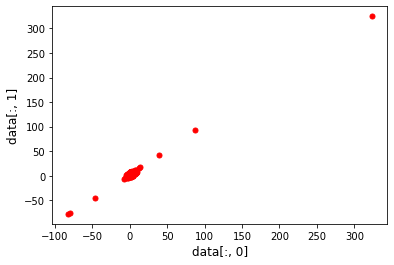

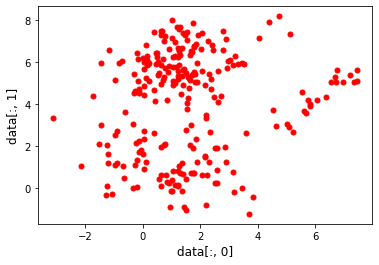

In [21]:
folder = np.load("samples.npz")
data = folder['data']
fig = plt.figure(figsize=(6,4))
plt.plot(data[:, 0], data[:, 1], linestyle='None', marker='o', markersize=5, color='navy')
plt.xlabel('data[:, 0]', fontsize=12)
plt.ylabel('data[:, 1]', fontsize=12)
plt.show()

noisy = data.copy()
for i in range(100):
    scale = np.random.standard_cauchy()
    random_point = np.random.randint(0, data.shape[0])
    noisy[random_point, 0] += scale
    noisy[random_point, 1] += scale
plt.plot(noisy[:, 0], noisy[:, 1], linestyle='None', marker='o', markersize=5, color='red')
plt.xlabel('data[:, 0]', fontsize=12)
plt.ylabel('data[:, 1]', fontsize=12)
plt.show()

data_fb = compute_fb((noisy - np.mean(0)).T, .95, 2)
plt.plot(data_fb[0, :], data_fb[1, :], linestyle='None', marker='o', markersize=5, color='red')
plt.xlabel('data[:, 0]', fontsize=12)
plt.ylabel('data[:, 1]', fontsize=12)
plt.show()

In [22]:
def plot_contours(data, means, covs):
    """visualize the gaussian components over the data"""
    plt.figure()
    plt.plot(data[:, 0], data[:, 1], 'ko')

    delta = 0.025
    k = means.shape[0]
    x = np.arange(-2.5, 10.0, delta)
    y = np.arange(-2.5, 10.0, delta)
    x_grid, y_grid = np.meshgrid(x, y)
    coordinates = np.array([x_grid.ravel(), y_grid.ravel()]).T

    col = ['green', 'red', 'indigo']
    for i in range(k):
        mean = means[i]
        cov = covs[i]
        z_grid = multivariate_normal(mean, cov).pdf(coordinates).reshape(x_grid.shape)
        plt.contour(x_grid, y_grid, z_grid, colors = col[i])
    plt.tight_layout()

<Figure size 1008x864 with 0 Axes>

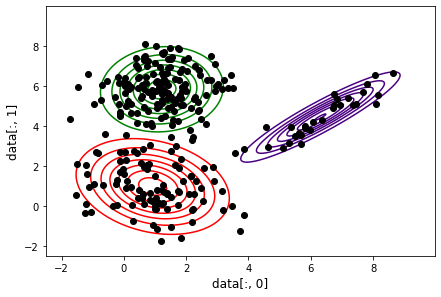

Original Mean: [[1.2215991  5.82962808]
 [0.92634336 0.96642033]
 [6.30978007 4.44084974]]
Original Cov: [[[ 0.94608142  0.07022242]
  [ 0.07022242  1.10721448]]

 [[ 1.50152004 -0.36222654]
  [-0.36222654  1.42453523]]

 [[ 1.67147566  1.36418616]
  [ 1.36418616  1.3030044 ]]]


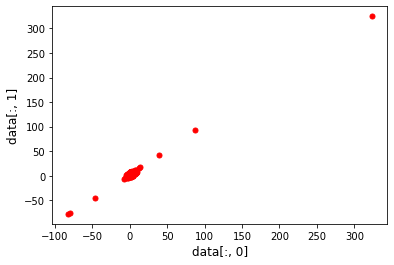

<Figure size 1008x864 with 0 Axes>

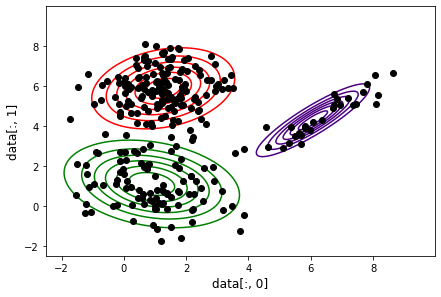

New Mean: [[0.89728505 1.09465557]
 [1.26530946 5.87798873]
 [6.07018605 4.27911547]]
New Cov: [[[ 2.06073035 -0.40670852]
  [-0.40670852  1.24947197]]

 [[ 1.380671    0.30043741]
  [ 0.30043741  1.07791209]]

 [[ 0.85976807  0.76812396]
  [ 0.76812396  0.86205344]]]


In [23]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, n_init=10)
gmm.fit(data)
fig= plt.figure(figsize=(14, 12))
plot_contours(data, gmm.means_, gmm.covariances_)
plt.xlabel("data[:, 0]", fontsize=12)
plt.ylabel("data[:, 1]", fontsize=12)
plt.show()
print(f"Original Mean: {gmm.means_}")
print(f"Original Cov: {gmm.covariances_}")

plt.plot(noisy[:, 0], noisy[:, 1], linestyle='None', marker='o', markersize=5, color='red')
plt.xlabel('data[:, 0]', fontsize=12)
plt.ylabel('data[:, 1]', fontsize=12)
plt.show()

gmm.fit(data_fb.T)
fig= plt.figure(figsize=(14, 12))
plot_contours(data, gmm.means_, gmm.covariances_)
plt.xlabel("data[:, 0]", fontsize=12)
plt.ylabel("data[:, 1]", fontsize=12)
plt.show()
print(f"New Mean: {gmm.means_}")
print(f"New Cov: {gmm.covariances_}")

[0.78503768 0.943309  ]


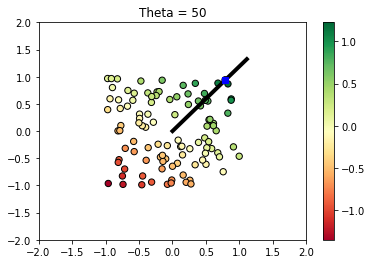

In [29]:
n = 103
U_x = np.random.uniform(-1,1,(1,n))
U_y = np.random.uniform(-1,1,(1,n))
U = np.vstack((U_x,U_y))
theta = 50
direction = np.array([np.cos(np.radians(theta)), np.sin(np.radians(theta))])
colors = [np.dot(U[:,i], direction) for i in range(n)]
scale = np.dot(U[:,np.argmax(colors)], direction)
print(U[:,np.argmax(colors)])
plt.title(f"Theta = {theta}")
plt.xlim([-2,2])
plt.ylim([-2,2])
plt.scatter(U[0,:], U[1,:], c=colors, cmap="RdYlGn", s=40, edgecolors="black");
plt.plot([0,direction[0]*(scale+.5)], [0, direction[1]*(scale+.5)], "k", linewidth=4)
plt.plot(direction[0]*scale, direction[1]*scale, "bs")
plt.colorbar()

    

In [4]:
def support(X, val, q): # Set q to be the qth quantile
    return np.quantile((X.T).dot(val), q)

def compute_fb(X, q, n):
    polar_body = np.ones((n,0))
    for i in range(X.shape[1]):
        if support(X, X[:,i] / la.norm(X[:,i]), q) > np.dot(X[:,i], X[:,i]/la.norm(X[:,i])): 
            polar_body = np.hstack((polar_body, np.array(X[:,i]).reshape(n,1)))
    return polar_body

In [5]:
def isInside(p1, p2, p3, p):
    area = triangleArea (p1, p2, p3)
    area1 = triangleArea (p, p2, p3)
    area2 = triangleArea (p1, p, p3)
    area3 = triangleArea (p1, p2, p)
    area_sum = area1 + area2 + area3
    if (area_sum - area < 1e-3):
        return True
def triangleArea(p1, p2, p3):
    return abs((p1[0]*(p2[1]-p3[1]) + p2[0]*(p3[1]-p1[1])+ p3[0]*(p1[1]-p2[1]))/2.0);

In [6]:
inside = 0

scale = .012
points = []
coupons = []
for theta in range(20, 90):
    print(f"Theta: {theta}")
    thetas_left = np.radians(90+theta/2)
    thetas_right = np.radians(90-theta/2)
    points_sum  = 0
    for pts in range(10000):
        U = np.random.uniform(-1,1,(2,pts))
        #plt.plot(U[0,:], U[1,:], "ko")
        #plt.plot([1,-1,-1,1,1], [1,1,-1,-1,1])
        u_left = max(np.abs(np.cos(thetas_left)),np.abs(np.sin(thetas_left)))
        u_right = max(np.abs(np.cos(thetas_right)),np.abs(np.sin(thetas_right)))
        tri = np.array([[0,0], 
                      [np.cos(thetas_left)*1/u_left,np.sin(thetas_left)/u_left], 
                      [np.cos(thetas_right)*1/u_right,np.sin(thetas_right)/u_right]])
        for j in range(0,pts):
            if isInside(tri[1,:], tri[2, :], tri[0,:], (U[0,j],U[1,j])):
                inside = inside + 1
                #plt.plot(U[0,j], U[1,j], 'ro', markersize=3)
        #plt.plot([0,np.cos(thetas_left)*1/u_left],[0,np.sin(thetas_left)*1/u_left], 'r')
        #plt.plot([0,np.cos(thetas_right)*1/u_right],[0,np.sin(thetas_right)*1/u_right], 'r')
        if(inside == math.ceil(1/(np.tan(np.radians(theta/2))/4)*np.log(1/(np.tan(np.radians(theta/2))/4)))):
            print(f"Samples: {pts}")
            points_sum += pts
            print(f"inside: {inside}")
            inside = 0
            break
        else:
            inside = 0
    points.append(points_sum)  
    coupons.append(math.ceil(1/(np.tan(np.radians(theta/2))/4)*np.log(1/(np.tan(np.radians(theta/2))/4))))


Theta: 20
Samples: 1233
inside: 71
Theta: 21


KeyboardInterrupt: 

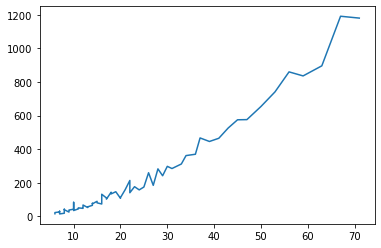

In [12]:
plt.plot(coupons, points)

In [7]:
import scipy.integrate as integrate

Theta: 1


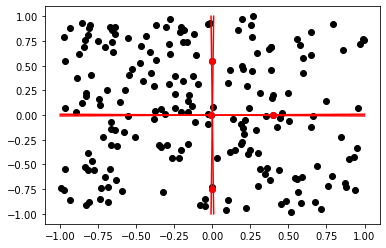

Theta: 1
Current pts: 203
tan(theta/2): 0.00872686779075879
simp = 145.55608096740886
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.00872686779075879
Samples: 922.1165892637878
Theta: 2


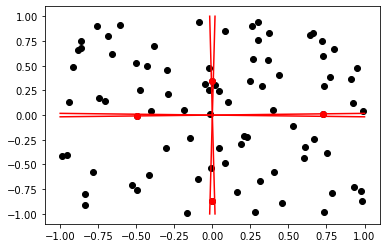

Theta: 2
Current pts: 86
tan(theta/2): 0.017455064928217585
simp = 72.7724978375815
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.017455064928217585
Samples: 461.0231812521958
Theta: 3


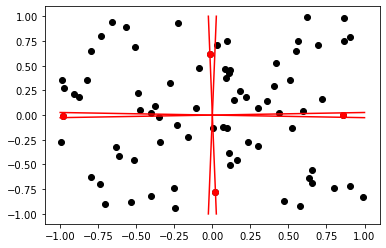

Theta: 3
Current pts: 78
tan(theta/2): 0.026185921569186928
simp = 48.50883981254512
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.026185921569186928
Samples: 307.30977105039756
Theta: 4


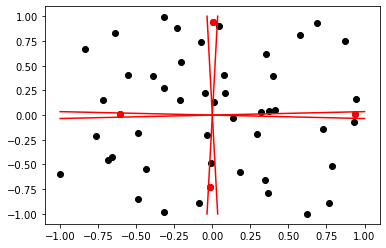

Theta: 4
Current pts: 50
tan(theta/2): 0.03492076949174773
simp = 36.37516278224443
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.03492076949174773
Samples: 230.4413585179492
Theta: 5


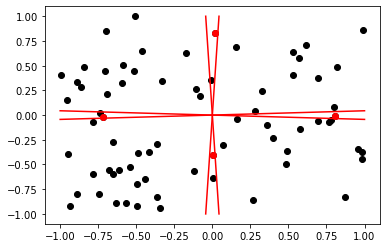

Theta: 5
Current pts: 72
tan(theta/2): 0.04366094290851206
simp = 29.093477834531914
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.04366094290851206
Samples: 184.3109430557359
Theta: 6


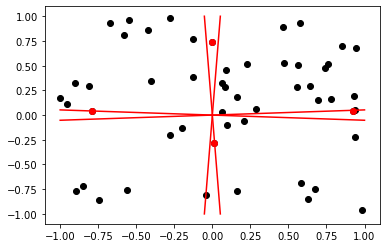

Theta: 6
Current pts: 52
tan(theta/2): 0.05240777928304121
simp = 24.237788590187456
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.05240777928304121
Samples: 153.54952398783507
Theta: 7


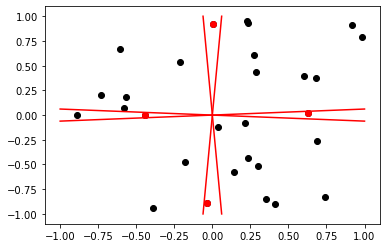

Theta: 7
Current pts: 29
tan(theta/2): 0.06116262015048431
simp = 20.768382250764326
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.06116262015048431
Samples: 131.57038633026548
Theta: 8


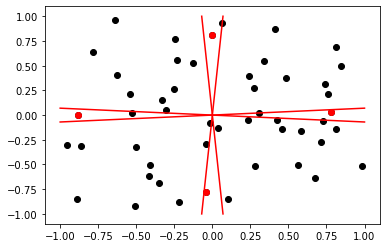

Theta: 8
Current pts: 50
tan(theta/2): 0.06992681194351041
simp = 18.165402360538256
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.06992681194351041
Samples: 115.08017223309612
Theta: 9


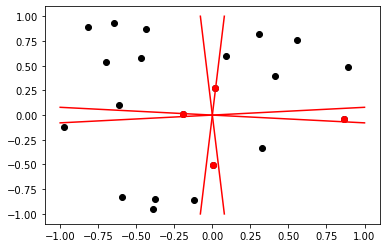

Theta: 9
Current pts: 21
tan(theta/2): 0.07870170682461845
simp = 16.14003972714625
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.07870170682461845
Samples: 102.24923812774647
Theta: 10


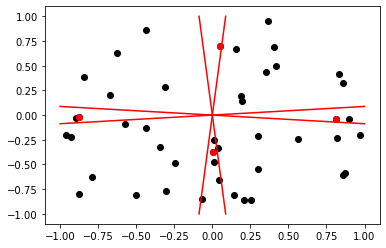

Theta: 10
Current pts: 45
tan(theta/2): 0.087488663525924
simp = 14.519008789832162
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.087488663525924
Samples: 91.979797585844
Theta: 11


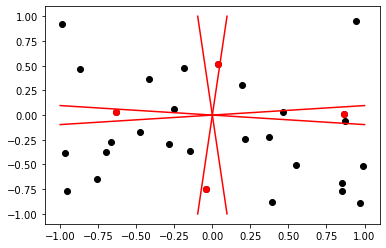

Theta: 11
Current pts: 29
tan(theta/2): 0.0962890481975386
simp = 13.192036877731125
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.0962890481975386
Samples: 83.57325898228382
Theta: 12


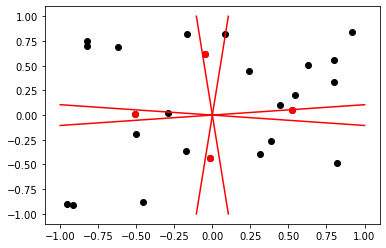

Theta: 12
Current pts: 25
tan(theta/2): 0.10510423526567647
simp = 12.085608839003461
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.10510423526567647
Samples: 76.56389432670602
Theta: 13


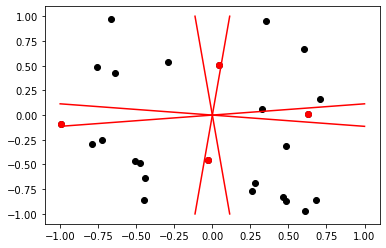

Theta: 13
Current pts: 25
tan(theta/2): 0.1139356083016455
simp = 11.14882953343756
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.1139356083016455
Samples: 70.62927632655015
Theta: 14


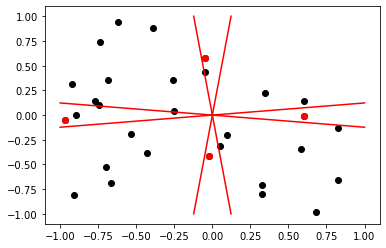

Theta: 14
Current pts: 30
tan(theta/2): 0.1227845609029046
simp = 10.345345256787164
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.1227845609029046
Samples: 65.53909956589776
Theta: 15


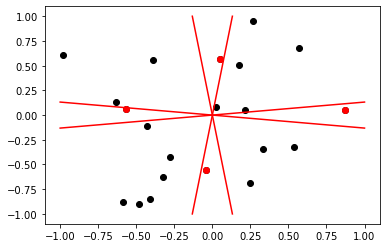

Theta: 15
Current pts: 21
tan(theta/2): 0.13165249758739583
simp = 9.64849659536706
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.13165249758739583
Samples: 61.1244732127355
Theta: 16


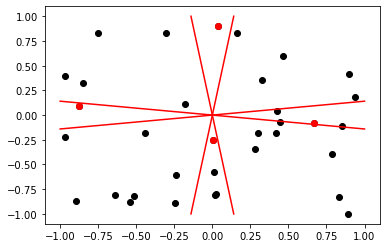

Theta: 16
Current pts: 34
tan(theta/2): 0.14054083470239143
simp = 9.038288960168988
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.14054083470239143
Samples: 57.25872896095423
Theta: 17


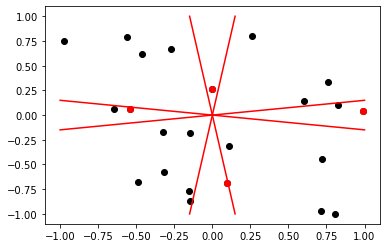

Theta: 17
Current pts: 23
tan(theta/2): 0.1494510013491278
simp = 8.499432344224784
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.1494510013491278
Samples: 53.84500263983989
Theta: 18


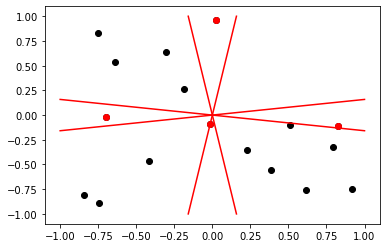

Theta: 18
Current pts: 17
tan(theta/2): 0.15838444032453627
simp = 8.020034494176112
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.15838444032453627
Samples: 50.807955287031206
Theta: 19


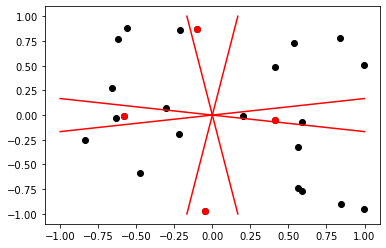

Theta: 19
Current pts: 24
tan(theta/2): 0.16734260908141957
simp = 7.590706764500886
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.16734260908141957
Samples: 48.0881086194562
Theta: 20


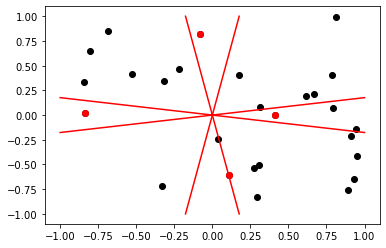

Theta: 20
Current pts: 27
tan(theta/2): 0.17632698070846498
simp = 7.203938215466635
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.17632698070846498
Samples: 45.63787986295496
Theta: 21


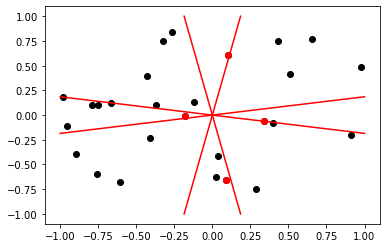

Theta: 21
Current pts: 27
tan(theta/2): 0.18533904493153439
simp = 6.853648540234995
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.18533904493153439
Samples: 43.41874948769264
Theta: 22


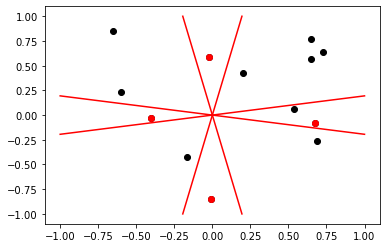

Theta: 22
Current pts: 13
tan(theta/2): 0.19438030913771848
simp = 6.53486292093294
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.19438030913771848
Samples: 41.39920137933862
Theta: 23


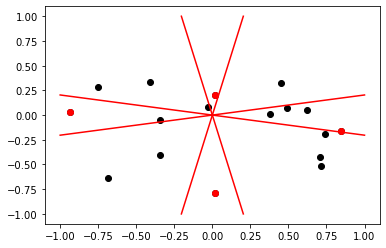

Theta: 23
Current pts: 17
tan(theta/2): 0.20345229942369938
simp = 6.243471704874683
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.20345229942369938
Samples: 39.55320035686515
Theta: 24


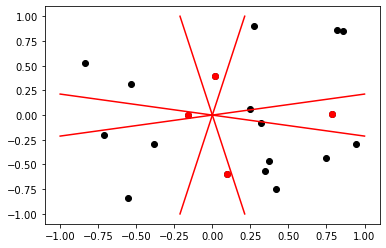

Theta: 24
Current pts: 19
tan(theta/2): 0.21255656167002213
simp = 5.97605016172365
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.21255656167002213
Samples: 37.85905031086808
Theta: 25


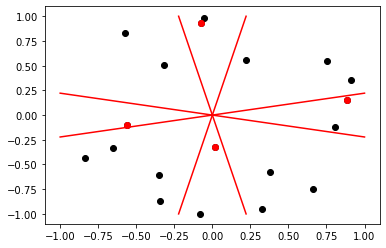

Theta: 25
Current pts: 19
tan(theta/2): 0.2216946626429399
simp = 5.729721498931229
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.2216946626429399
Samples: 36.29852638866303
Theta: 26


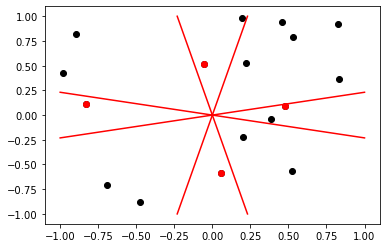

Theta: 26
Current pts: 17
tan(theta/2): 0.23086819112556312
simp = 5.502051488993146
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.23086819112556312
Samples: 34.8562074443328
Theta: 27


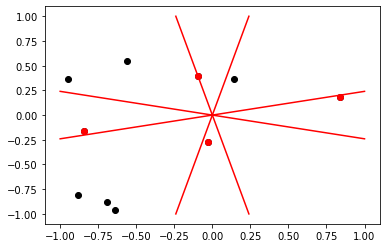

Theta: 27
Current pts: 10
tan(theta/2): 0.24007875908011603
simp = 5.290966512867003
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.24007875908011603
Samples: 33.5189568331828
Theta: 28


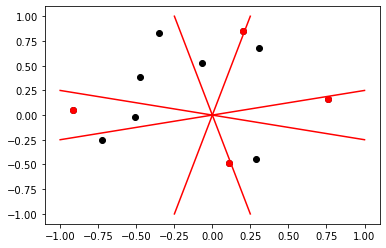

Theta: 28
Current pts: 11
tan(theta/2): 0.2493280028431807
simp = 5.09468916551064
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.2493280028431807
Samples: 32.27551446450211
Theta: 29


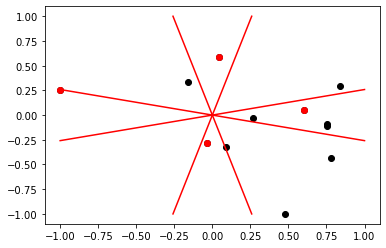

Theta: 29
Current pts: 12
tan(theta/2): 0.25861758435589033
simp = 4.911687184408686
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.25861758435589033
Samples: 31.116173257177117
Theta: 30


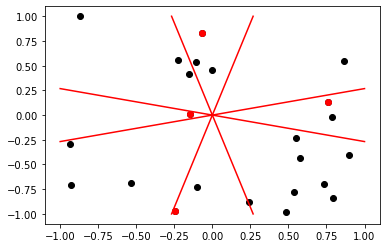

Theta: 30
Current pts: 23
tan(theta/2): 0.2679491924311227
simp = 4.7406325923899955
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.2679491924311227
Samples: 30.03252030415826
Theta: 31


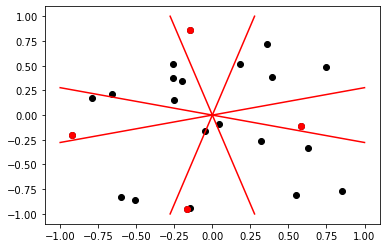

Theta: 31
Current pts: 23
tan(theta/2): 0.2773245440598384
simp = 4.580368748283155
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.2773245440598384
Samples: 29.017228134103256
Theta: 32


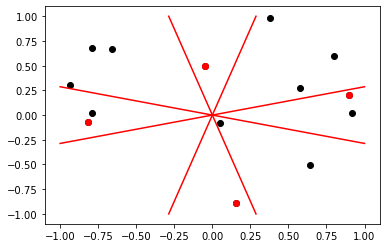

Theta: 32
Current pts: 14
tan(theta/2): 0.2867453857588079
simp = 4.42988357557046
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.2867453857588079
Samples: 28.063885111439205
Theta: 33


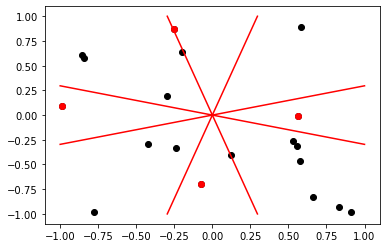

Theta: 33
Current pts: 19
tan(theta/2): 0.29621349496208027
simp = 4.288287658555764
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.29621349496208027
Samples: 27.16685667275443
Theta: 34


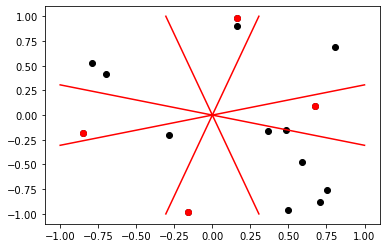

Theta: 34
Current pts: 15
tan(theta/2): 0.3057306814586604
simp = 4.154796203910979
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.3057306814586604
Samples: 26.32117105086363
Theta: 35


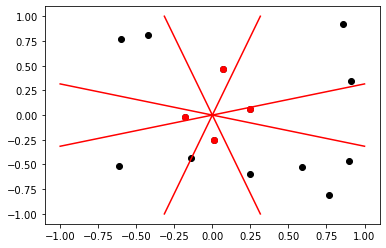

Theta: 35
Current pts: 14
tan(theta/2): 0.3152987888789835
simp = 4.02871409452543
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.3152987888789835
Samples: 25.52242458901146
Theta: 36


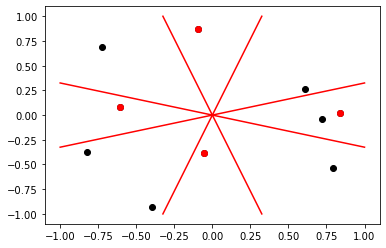

Theta: 36
Current pts: 10
tan(theta/2): 0.3249196962329063
simp = 3.9094234343769347
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.3249196962329063
Samples: 24.76670283602069
Theta: 37


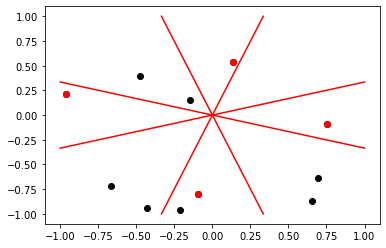

Theta: 37
Current pts: 11
tan(theta/2): 0.33459531950207316
simp = 3.7963731131501626
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.33459531950207316
Samples: 24.050514436800544
Theta: 38


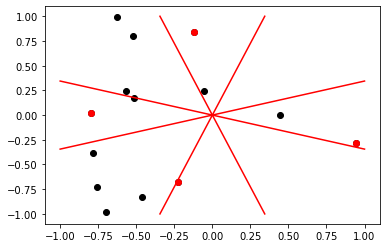

Theta: 38
Current pts: 14
tan(theta/2): 0.34432761328966527
simp = 3.6890700185435414
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.34432761328966527
Samples: 23.37073546117491
Theta: 39


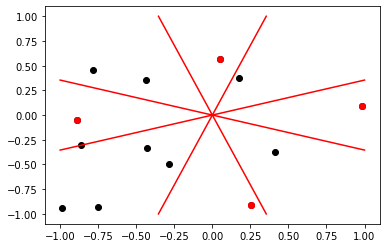

Theta: 39
Current pts: 13
tan(theta/2): 0.354118572530698
simp = 3.5870716005256766
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.354118572530698
Samples: 22.724562297485548
Theta: 40


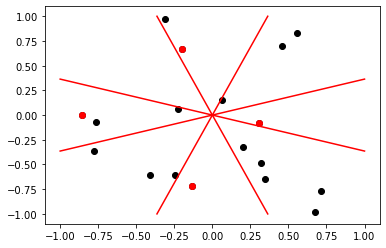

Theta: 40
Current pts: 18
tan(theta/2): 0.36397023426620234
simp = 3.4899795509500873
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.36397023426620234
Samples: 22.10947161213438
Theta: 41


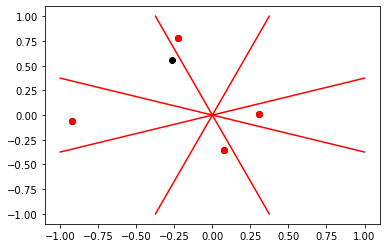

Theta: 41
Current pts: 5
tan(theta/2): 0.3738846794848047
simp = 3.3974344081011854
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.3738846794848047
Samples: 21.52318616868481
Theta: 42


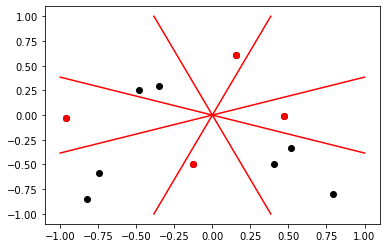

Theta: 42
Current pts: 11
tan(theta/2): 0.3838640350354158
simp = 3.309110932016239
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.3838640350354158
Samples: 20.963645529928474
Theta: 43


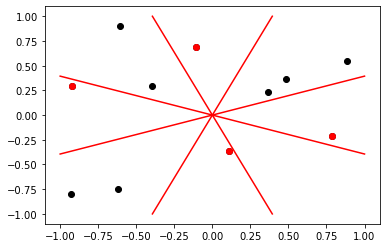

Theta: 43
Current pts: 11
tan(theta/2): 0.3939104756149424
simp = 3.2247141251081106
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.3939104756149424
Samples: 20.42898084801592
Theta: 44


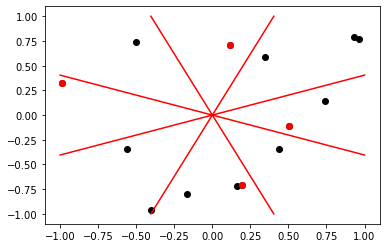

Theta: 44
Current pts: 14
tan(theta/2): 0.4040262258351568
simp = 3.143975795427255
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.4040262258351568
Samples: 19.91749309227705
Theta: 45


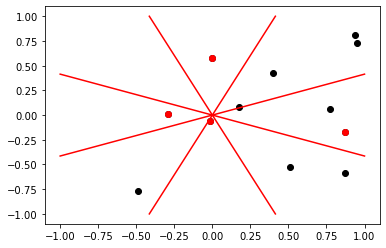

Theta: 45
Current pts: 12
tan(theta/2): 0.4142135623730951
simp = 3.06665157815235
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.4142135623730951
Samples: 19.427634179979233
Theta: 46


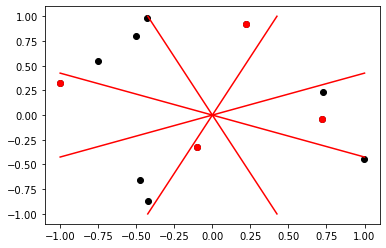

Theta: 46
Current pts: 11
tan(theta/2): 0.42447481620960476
simp = 2.9925183455790996
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.42447481620960476
Samples: 18.957990568271587
Theta: 47


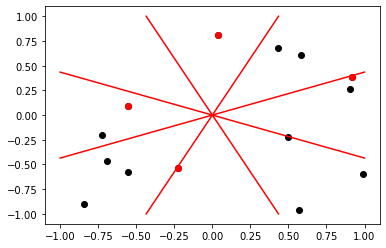

Theta: 47
Current pts: 14
tan(theta/2): 0.43481237496093356
simp = 2.9213719477457065
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.43481237496093356
Samples: 18.507268940755228
Theta: 48


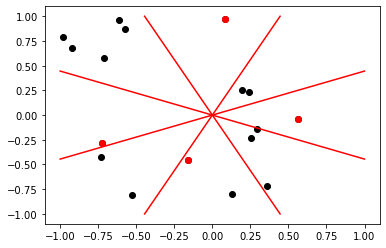

Theta: 48
Current pts: 17
tan(theta/2): 0.44522868530853615
simp = 2.8530252354771286
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.44522868530853615
Samples: 18.074283683213114
Theta: 49


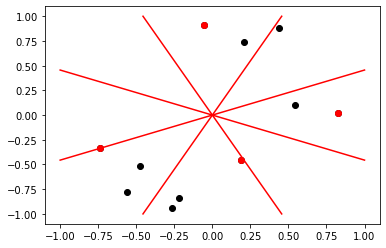

Theta: 49
Current pts: 11
tan(theta/2): 0.45572625553258467
simp = 2.787306325502537
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.45572625553258467
Samples: 17.65794589290483
Theta: 50


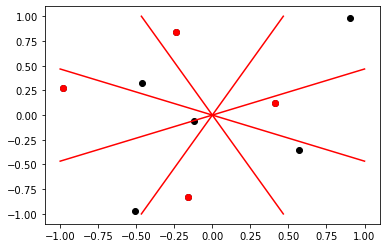

Theta: 50
Current pts: 9
tan(theta/2): 0.46630765815499864
simp = 2.724057073755657
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.46630765815499864
Samples: 17.257253706726924
Theta: 51


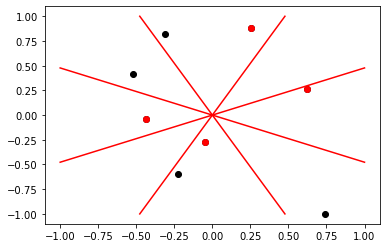

Theta: 51
Current pts: 8
tan(theta/2): 0.4769755326981602
simp = 2.6631317282838447
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.4769755326981602
Samples: 16.871283767217736
Theta: 52


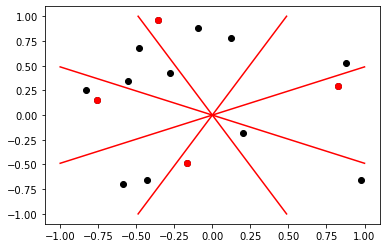

Theta: 52
Current pts: 15
tan(theta/2): 0.4877325885658614
simp = 2.604395737587729
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.4877325885658614
Samples: 16.499183673234995
Theta: 53


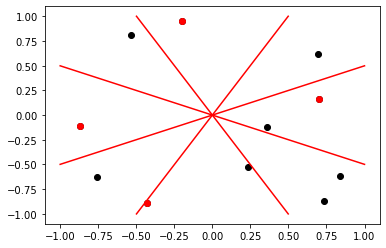

Theta: 53
Current pts: 11
tan(theta/2): 0.49858160805343144
simp = 2.5477246938628153
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.49858160805343144
Samples: 16.140165285254785
Theta: 54


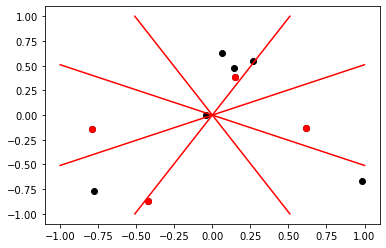

Theta: 54
Current pts: 10
tan(theta/2): 0.5095254494944288
simp = 2.493003393655704
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.5095254494944288
Samples: 15.79349877450722
Theta: 55


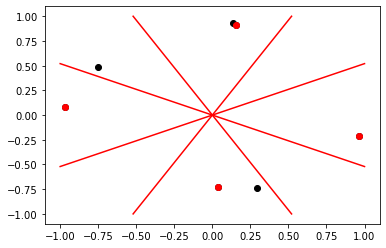

Theta: 55
Current pts: 7
tan(theta/2): 0.5205670505517462
simp = 2.4401250009911863
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.5205670505517462
Samples: 15.458507321278457
Theta: 56


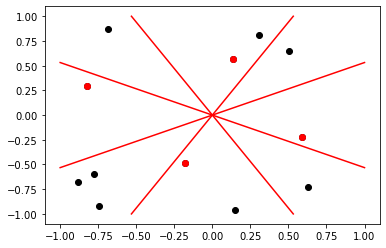

Theta: 56
Current pts: 12
tan(theta/2): 0.5317094316614788
simp = 2.388990300161316
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.5317094316614788
Samples: 15.134562381232824
Theta: 57


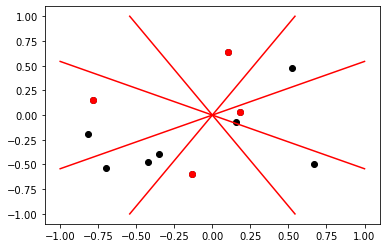

Theta: 57
Current pts: 11
tan(theta/2): 0.5429556996384369
simp = 2.33950702716527
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.5429556996384369
Samples: 14.821079449997958
Theta: 58


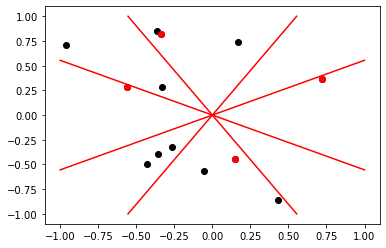

Theta: 58
Current pts: 13
tan(theta/2): 0.554309051452769
simp = 2.291589270307618
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.554309051452769
Samples: 14.517514265877324
Theta: 59


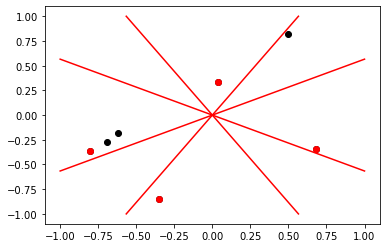

Theta: 59
Current pts: 7
tan(theta/2): 0.5657727781877702
simp = 2.245156931749702
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.5657727781877702
Samples: 14.223359398708608
Theta: 60


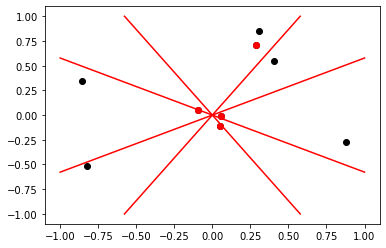

Theta: 60
Current pts: 9
tan(theta/2): 0.5773502691896256
simp = 2.2001352429028778
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.5773502691896256
Samples: 13.938141179817261
Theta: 61


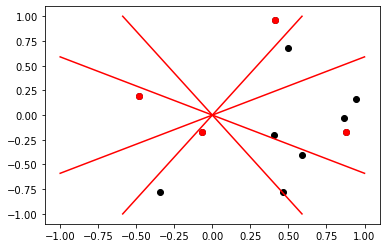

Theta: 61
Current pts: 11
tan(theta/2): 0.589045016420551
simp = 2.156454327484981
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.589045016420551
Samples: 13.66141693392272
Theta: 62


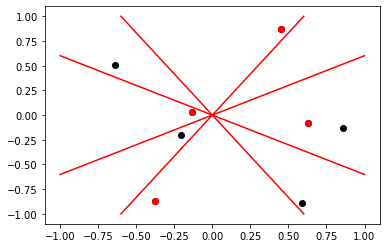

Theta: 62
Current pts: 8
tan(theta/2): 0.6008606190275603
simp = 2.114048806858642
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.6008606190275603
Samples: 13.392772478905616
Theta: 63


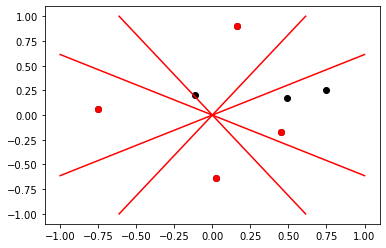

Theta: 63
Current pts: 7
tan(theta/2): 0.6128007881399319
simp = 2.072857442953386
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.6128007881399319
Samples: 13.13181986367312
Theta: 64


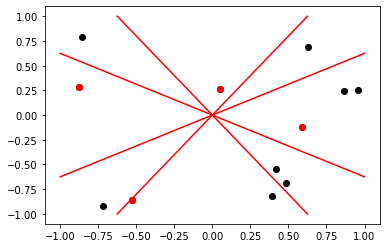

Theta: 64
Current pts: 12
tan(theta/2): 0.6248693519093275
simp = 2.0328228146607517
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.6248693519093275
Samples: 12.878195318080186
Theta: 65


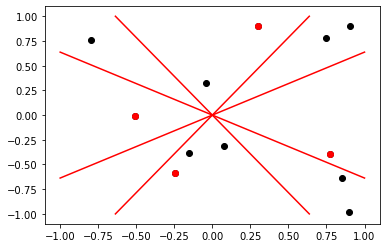

Theta: 65
Current pts: 12
tan(theta/2): 0.6370702608074932
simp = 1.9938910240975705
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.6370702608074932
Samples: 12.631557392069448
Theta: 66


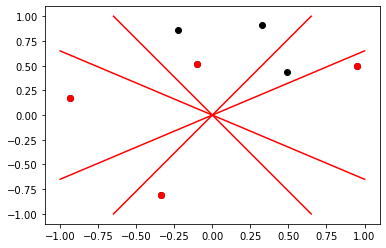

Theta: 66
Current pts: 7
tan(theta/2): 0.6494075931975105
simp = 1.9560114295695123
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.6494075931975105
Samples: 12.39158526396077
Theta: 67


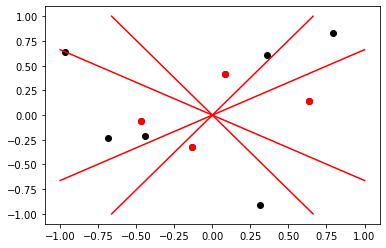

Theta: 67
Current pts: 10
tan(theta/2): 0.6618855611956915
simp = 1.9191364024452562
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.6618855611956915
Samples: 12.15797720021768
Theta: 68


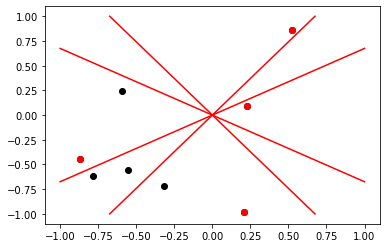

Theta: 68
Current pts: 8
tan(theta/2): 0.6745085168424267
simp = 1.8832211054798351
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.6745085168424267
Samples: 11.930449151097111
Theta: 69


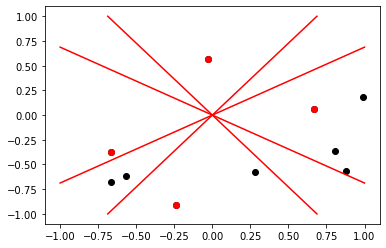

Theta: 69
Current pts: 10
tan(theta/2): 0.6872809586016132
simp = 1.8482232904110858
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.6872809586016132
Samples: 11.708733468396739
Theta: 70


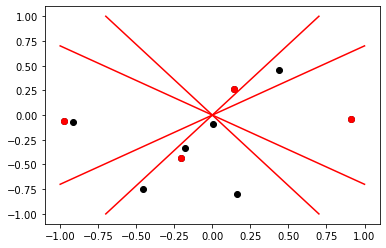

Theta: 70
Current pts: 10
tan(theta/2): 0.7002075382097097
simp = 1.8141031129018264
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.7002075382097097
Samples: 11.492577733089751
Theta: 71


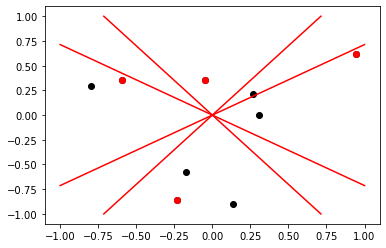

Theta: 71
Current pts: 9
tan(theta/2): 0.7132930678970054
simp = 1.7808229631175583
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.7132930678970054
Samples: 11.281743682012706
Theta: 72


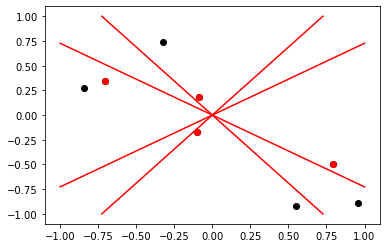

Theta: 72
Current pts: 8
tan(theta/2): 0.7265425280053609
simp = 1.7483473104195026
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.7265425280053609
Samples: 11.076006223975817
Theta: 73


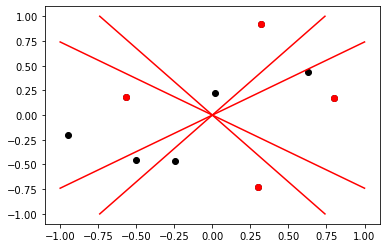

Theta: 73
Current pts: 9
tan(theta/2): 0.7399610750284875
simp = 1.7166425608193727
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.7399610750284875
Samples: 10.875152536720524
Theta: 74


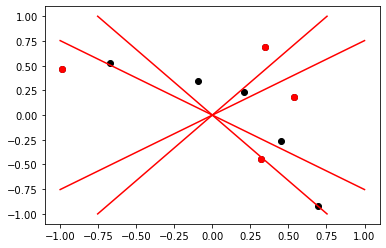

Theta: 74
Current pts: 9
tan(theta/2): 0.7535540501027942
simp = 1.6856769259886282
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.7535540501027942
Samples: 10.678981237076178
Theta: 75


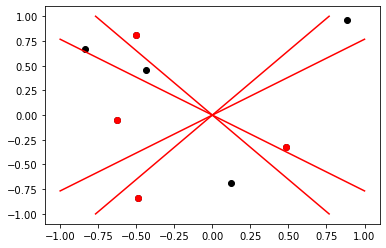

Theta: 75
Current pts: 8
tan(theta/2): 0.7673269879789604
simp = 1.655420302743722
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.7673269879789604
Samples: 10.48730161748351
Theta: 76


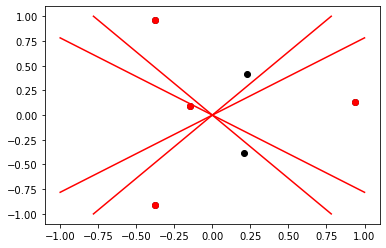

Theta: 76
Current pts: 6
tan(theta/2): 0.7812856265067175
simp = 1.6258441620423658
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.7812856265067175
Samples: 10.299932942771617
Theta: 77


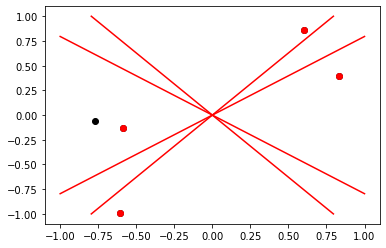

Theta: 77
Current pts: 5
tan(theta/2): 0.7954359166678284
simp = 1.5969214466261155
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.7954359166678284
Samples: 10.116703801710507
Theta: 78


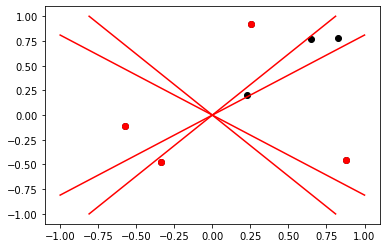

Theta: 78
Current pts: 7
tan(theta/2): 0.809784033195007
simp = 1.5686264765332385
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.809784033195007
Samples: 9.9374515084229
Theta: 79


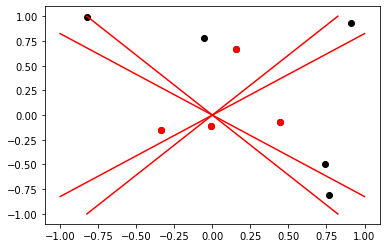

Theta: 79
Current pts: 9
tan(theta/2): 0.8243363858174957
simp = 1.5409348617844294
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.8243363858174957
Samples: 9.762021549236955
Theta: 80


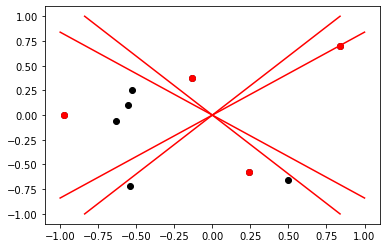

Theta: 80
Current pts: 9
tan(theta/2): 0.8390996311772798
simp = 1.5138234216136708
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.8390996311772798
Samples: 9.590267071003325
Theta: 81


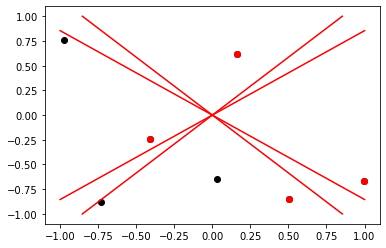

Theta: 81
Current pts: 7
tan(theta/2): 0.8540806854634665
simp = 1.4872701096785241
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.8540806854634665
Samples: 9.422048407292689
Theta: 82


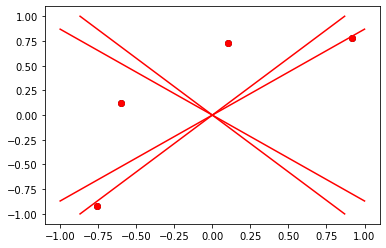

Theta: 82
Current pts: 4
tan(theta/2): 0.8692867378162267
simp = 1.461253944739346
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.8692867378162267
Samples: 9.257232639239612
Theta: 83


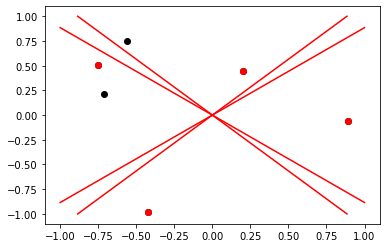

Theta: 83
Current pts: 6
tan(theta/2): 0.8847252645559439
simp = 1.4357549463461006
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.8847252645559439
Samples: 9.095693188110209
Theta: 84


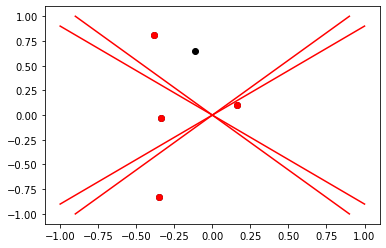

Theta: 84
Current pts: 5
tan(theta/2): 0.9004040442978399
simp = 1.4107540751153933
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.9004040442978399
Samples: 8.937309436949413
Theta: 85


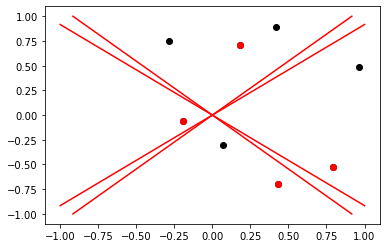

Theta: 85
Current pts: 8
tan(theta/2): 0.9163311740174235
simp = 1.3862331772196215
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.9163311740174235
Samples: 8.781966378912575
Theta: 86


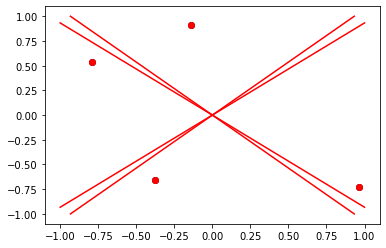

Theta: 86
Current pts: 4
tan(theta/2): 0.9325150861376617
simp = 1.3621749327453128
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.9325150861376617
Samples: 8.62955429010887
Theta: 87


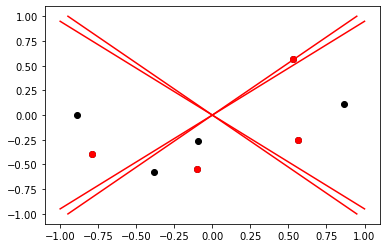

Theta: 87
Current pts: 8
tan(theta/2): 0.9489645667148795
simp = 1.338562807609244
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.9489645667148795
Samples: 8.479968424983685
Theta: 88


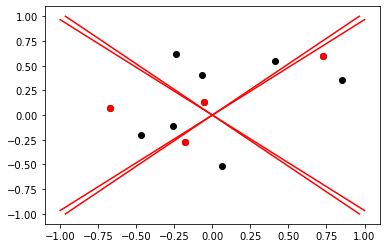

Theta: 88
Current pts: 11
tan(theta/2): 0.9656887748070739
simp = 1.3153810087492528
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.9656887748070739
Samples: 8.333108732446616
Theta: 89


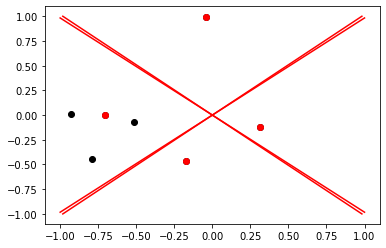

Theta: 89
Current pts: 7
tan(theta/2): 0.9826972631156901
simp = 1.29261444233209
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.9826972631156901
Samples: 8.188879591112823
Theta: 90


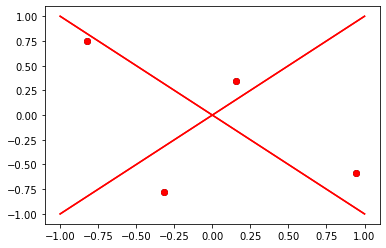

Theta: 90
Current pts: 4
tan(theta/2): 0.9999999999999999
simp = 1.270248674743559
N = 5
EX = nlog(n): 8.047189562170502
Probability: 0.9999999999999999
Samples: 8.047189562170503


In [6]:
inside = 0

scale = .012
points = []
coupons = []
for theta in range(1, 91):
    print(f"Theta: {theta}")
    A_left = np.radians(90+theta/2)
    A_right = np.radians(90-theta/2)
    B_left = np.radians(180+theta/2)
    B_right = np.radians(180-theta/2)
    C_left = np.radians(270+theta/2)
    C_right = np.radians(270-theta/2)
    D_left = np.radians(theta/2)
    D_right = np.radians(360-theta/2)
    A = (A_left, A_right)
    B = (B_left, B_right)
    C = (C_left, C_right)
    D = (D_left, D_right)
    sets = list((A, B, C, D))
    for pts in range(10000):
        U = np.random.uniform(-1,1,(2,pts))
        count = 0
        js = []
        for letter in sets:
            u_left = max(np.abs(np.cos(letter[0])),np.abs(np.sin(letter[0])))
            u_right = max(np.abs(np.cos(letter[1])),np.abs(np.sin(letter[1])))
            
            tri = np.array([[0,0], 
                          [np.cos(letter[0])*1/u_left,np.sin(letter[0])/u_left], 
                          [np.cos(letter[1])*1/u_right,np.sin(letter[1])/u_right]])
            for j in range(0,pts):
                if isInside(tri[1,:], tri[2, :], tri[0,:], (U[0,j],U[1,j])):
                    js.append(j)
                    count +=1
                    break
        
        
        if count == 4:
            break
    plt.plot(U[0,:], U[1,:], 'ko')
    plt.plot([U[0,i] for i in js], [U[1,i] for i in js], 'ro')
    for letter in sets:
            u_left = max(np.abs(np.cos(letter[0])),np.abs(np.sin(letter[0])))
            u_right = max(np.abs(np.cos(letter[1])),np.abs(np.sin(letter[1])))
            
            plt.plot([0,np.cos(letter[0])*1/u_left],[0,np.sin(letter[0])*1/u_left], 'r')
            plt.plot([0,np.cos(letter[1])*1/u_right],[0,np.sin(letter[1])*1/u_right], 'r')
    plt.show()
    points.append(pts)  
    coupons.append(math.ceil(1/(np.tan(np.radians(theta/2))/4)*np.log(1/(np.tan(np.radians(theta/2))/4))))
    print("="*20)
    print("="*20)
    print(f"Theta: {theta}")
    print("="*20)
    print("="*20)
    print(f"Current pts: {pts}")
    print("="*20)
    print("="*20)
    print(f"tan(theta/2): {(np.tan(np.radians(theta/2)))}")
    p = (np.tan(np.radians(theta/2)))
    N = 4
    print(f"simp = {(np.log(4)*(np.log(1/.4)))/p}")
    print(f"N = {N}")
    EX = ((N)*np.log(N))
    print(f"EX = nlog(n): {EX}")
    print(f"Probability: {p}")
    print(f"Samples: {((N)*np.log(N))/(p)}")
    print("="*20)
    print("="*20)

In [140]:
inside = 0
num_tests = 100
scale = .012
points = []
coupons = []
for theta in range(1, 91):
    print(f"Theta: {theta}")
    A_left = np.radians(90+theta/2)
    A_right = np.radians(90-theta/2)
    B_left = np.radians(180+theta/2)
    B_right = np.radians(180-theta/2)
    C_left = np.radians(270+theta/2)
    C_right = np.radians(270-theta/2)
    D_left = np.radians(theta/2)
    D_right = np.radians(360-theta/2)
    A = (A_left, A_right)
    B = (B_left, B_right)
    C = (C_left, C_right)
    D = (D_left, D_right)
    sets = list((A, B, C, D))
    sum_of_pts = 0
    for test in range(num_tests):
        for thresh in range(100000):
            U = np.random.uniform(-1,1,(2,4))
            count = 0
            js = []
            for letter in sets:
                u_left = max(np.abs(np.cos(letter[0])),np.abs(np.sin(letter[0])))
                u_right = max(np.abs(np.cos(letter[1])),np.abs(np.sin(letter[1])))

                tri = np.array([[0,0], 
                              [np.cos(letter[0])*1/u_left,np.sin(letter[0])/u_left], 
                              [np.cos(letter[1])*1/u_right,np.sin(letter[1])/u_right]])
                for j in range(0,pts):
                    if isInside(tri[1,:], tri[2, :], tri[0,:], (U[0,j],U[1,j])):
                        js.append(j)
                        count +=1
                        break


            if count == 4:
                break
        sum_of_pts += pts
        #plt.plot(U[0,:], U[1,:], 'ko')
        #plt.plot([U[0,i] for i in js], [U[1,i] for i in js], 'ro')
        #for letter in sets:
                #u_left = max(np.abs(np.cos(letter[0])),np.abs(np.sin(letter[0])))
                #u_right = max(np.abs(np.cos(letter[1])),np.abs(np.sin(letter[1])))

                #plt.plot([0,np.cos(letter[0])*1/u_left],[0,np.sin(letter[0])*1/u_left], 'r')
                #plt.plot([0,np.cos(letter[1])*1/u_right],[0,np.sin(letter[1])*1/u_right], 'r')
        #plt.show()
    points.append(sum_of_pts/num_tests)  
    coupons.append(math.ceil(1/(np.tan(np.radians(theta/2)))*np.log(1/(np.tan(np.radians(theta/2))))))
    print("="*20)
    print("="*20)
    print(f"Theta: {theta}")
    print("="*20)
    print("="*20)
    print(f"Current pts: {pts}")
    print("="*20)
    print("="*20)
    print(f"2*tan(theta/2): {(np.tan(np.radians(theta/2)))}")
    p = (np.tan(np.radians(theta/2)))
    N = 4
    print(f"N = {N}")
    print(f"Probability: {p}")
    print(f"Samples: {(N+1)/p*(np.log(N))}")
    print("="*20)
    print("="*20)

Theta: 1
Theta: 1
Current pts: 149
2*tan(theta/2): 0.01745373558151758
N = 4
Probability: 0.00872686779075879
Samples: 794.2679976130096
Theta: 2
Theta: 2
Current pts: 106
2*tan(theta/2): 0.03491012985643517
N = 4
Probability: 0.017455064928217585
Samples: 397.10375378748336
Theta: 3
Theta: 3
Current pts: 49
2*tan(theta/2): 0.052371843138373855
N = 4
Probability: 0.026185921569186928
Samples: 264.7022289166153
Theta: 4
Theta: 4
Current pts: 57
2*tan(theta/2): 0.06984153898349546
N = 4
Probability: 0.03492076949174773
Samples: 198.4913822485343
Theta: 5
Theta: 5
Current pts: 45
2*tan(theta/2): 0.08732188581702412
N = 4
Probability: 0.04366094290851206
Samples: 158.75680514101097
Theta: 6
Theta: 6
Current pts: 77
2*tan(theta/2): 0.10481555856608242
N = 4
Probability: 0.05240777928304121
Samples: 132.26036096977742
Theta: 7
Theta: 7
Current pts: 28
2*tan(theta/2): 0.12232524030096863
N = 4
Probability: 0.06116262015048431
Samples: 113.3285622582107
Theta: 8
Theta: 8
Current pts: 61
2*tan(

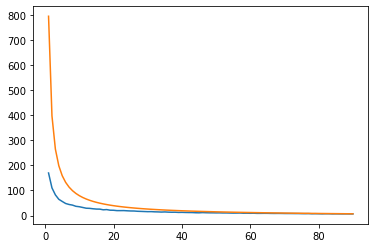

In [207]:
plt.plot([i for i in range(1,91)], points)
plt.plot([i for i in range(1,91)], [(N+1)/p*(np.log(N)) for p in ps])

In [8]:
ps = [(np.tan(np.radians(theta/2))) for theta in range(1,91)]

In [9]:
ps

[0.00872686779075879,
 0.017455064928217585,
 0.026185921569186928,
 0.03492076949174773,
 0.04366094290851206,
 0.05240777928304121,
 0.06116262015048431,
 0.06992681194351041,
 0.07870170682461845,
 0.087488663525924,
 0.0962890481975386,
 0.10510423526567647,
 0.1139356083016455,
 0.1227845609029046,
 0.13165249758739583,
 0.14054083470239143,
 0.1494510013491278,
 0.15838444032453627,
 0.16734260908141957,
 0.17632698070846498,
 0.18533904493153439,
 0.19438030913771848,
 0.20345229942369938,
 0.21255656167002213,
 0.2216946626429399,
 0.23086819112556312,
 0.24007875908011603,
 0.2493280028431807,
 0.25861758435589033,
 0.2679491924311227,
 0.2773245440598384,
 0.2867453857588079,
 0.29621349496208027,
 0.3057306814586604,
 0.3152987888789835,
 0.3249196962329063,
 0.33459531950207316,
 0.34432761328966527,
 0.354118572530698,
 0.36397023426620234,
 0.3738846794848047,
 0.3838640350354158,
 0.3939104756149424,
 0.4040262258351568,
 0.4142135623730951,
 0.42447481620960476,
 0.4348

In [14]:
import random
no_simulation=10000
total_coupon_numbers=4
theta_results = []
for theta in range(1,91):
    print(theta)
    coupon_number_set=set()
    flag=False
    boxes_no=0
    total_attempts = 0
    for i in range(no_simulation):
        counter=0
        coupon_number_set=set()
        flag=False
        num_of_attempts = 0
        while not flag:
            num_of_attempts += 1
            if (random.randint(1,100) <= round((np.tan(np.radians(theta/2))), 2)*100):
                coupon=random.randint(1,total_coupon_numbers)     
                counter+=1
                if len(coupon_number_set)==total_coupon_numbers:
                    total_attempts += num_of_attempts
                    boxes_no+=counter
                    flag=True;

                    #print boxes_no

                else:
                    #print coupon_number_set
                    coupon_number_set.add(coupon)
        
    theta_results.append(total_attempts/no_simulation)
print(boxes_no)           
avg_boxes= (boxes_no * 1.0)/no_simulation
print(f'avg number of boxes to make a complete set: {avg_boxes}')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
93330
avg number of boxes to make a complete set: 9.333


In [10]:
def bound(n, delta, theta):
    ep = 2*np.sin(np.radians(90-theta/2))*np.sin(np.radians(theta/2))
    return (math.pi * n * n)/(6*delta*ep*ep)

In [15]:
inside = 0
num_tests = 100
scale = .012
attempts = []
for theta in range(1, 91):
    print(f"Theta: {theta}")
    A_left = np.radians(90+theta/2)
    A_right = np.radians(90-theta/2)
    B_left = np.radians(180+theta/2)
    B_right = np.radians(180-theta/2)
    C_left = np.radians(270+theta/2)
    C_right = np.radians(270-theta/2)
    D_left = np.radians(theta/2)
    D_right = np.radians(360-theta/2)
    A = (A_left, A_right)
    B = (B_left, B_right)
    C = (C_left, C_right)
    D = (D_left, D_right)
    sets = list((A, B, C, D))
    sum_of_pts = 0
    for test in range(num_tests):
        trials = 0
        U = np.random.uniform(-1,1,(2,3))
        for thresh in range(1000):
            trials += 1
            U = np.hstack((U, np.random.uniform(-1,1,(2,1))))
            count = 0
            js = []
            for letter in sets:
                u_left = max(np.abs(np.cos(letter[0])),np.abs(np.sin(letter[0])))
                u_right = max(np.abs(np.cos(letter[1])),np.abs(np.sin(letter[1])))

                tri = np.array([[0,0], 
                              [np.cos(letter[0])*1/u_left,np.sin(letter[0])/u_left], 
                              [np.cos(letter[1])*1/u_right,np.sin(letter[1])/u_right]])
                for j in range(0,3+trials):
                    if isInside(tri[1,:], tri[2, :], tri[0,:], (U[0,j],U[1,j])):
                        js.append(j)
                        count +=1
                        break


            if count == 4:
                break
        sum_of_pts += trials
    attempts.append(sum_of_pts/num_tests) 
    #plt.plot(U[0,:], U[1,:], 'ko')
    #plt.plot([U[0,i] for i in js], [U[1,i] for i in js], 'ro')
    #for letter in sets:
            #u_left = max(np.abs(np.cos(letter[0])),np.abs(np.sin(letter[0])))
            #u_right = max(np.abs(np.cos(letter[1])),np.abs(np.sin(letter[1])))

            #plt.plot([0,np.cos(letter[0])*1/u_left],[0,np.sin(letter[0])*1/u_left], 'r')
            #plt.plot([0,np.cos(letter[1])*1/u_right],[0,np.sin(letter[1])*1/u_right], 'r')
    #plt.show()
    print("="*20)
    print("="*20)
    print(f"Theta: {trials}")
    print("="*20)
    print("="*20)
    print(f"Current pts: {pts}")
    print("="*20)
    print("="*20)
    print(f"2*tan(theta/2): {(np.tan(np.radians(theta/2)))}")
    p = (np.tan(np.radians(theta/2)))
    N = 4
    print(f"N = {N}")
    print(f"Probability: {p}")
    print(f"Samples: {(N+1)/p*(np.log(N))}")
    print("="*20)
    print("="*20)

Theta: 1
Theta: 1000
Current pts: 517
2*tan(theta/2): 0.00872686779075879
N = 4
Probability: 0.00872686779075879
Samples: 794.2679976130096
Theta: 2
Theta: 470
Current pts: 517
2*tan(theta/2): 0.017455064928217585
N = 4
Probability: 0.017455064928217585
Samples: 397.10375378748336
Theta: 3
Theta: 337
Current pts: 517
2*tan(theta/2): 0.026185921569186928
N = 4
Probability: 0.026185921569186928
Samples: 264.7022289166153
Theta: 4
Theta: 404
Current pts: 517
2*tan(theta/2): 0.03492076949174773
N = 4
Probability: 0.03492076949174773
Samples: 198.4913822485343
Theta: 5
Theta: 230
Current pts: 517
2*tan(theta/2): 0.04366094290851206
N = 4
Probability: 0.04366094290851206
Samples: 158.75680514101097
Theta: 6
Theta: 99
Current pts: 517
2*tan(theta/2): 0.05240777928304121
N = 4
Probability: 0.05240777928304121
Samples: 132.26036096977742
Theta: 7
Theta: 49
Current pts: 517
2*tan(theta/2): 0.06116262015048431
N = 4
Probability: 0.06116262015048431
Samples: 113.3285622582107
Theta: 8
Theta: 115
C

In [1]:
delta = .0001
N=4
plt.plot([i for i in range(1,91)], attempts, "r", label="emp trials")
plt.plot([i for i in range(1,91)], [np.ceil((1/(p)))*N*(np.log(N)) for p in ps], label="1/p*N*log(N)")
#plt.plot([i for i in range(1,91)], [(1/p)*(np.log(1/p)) for p in ps], label="1/plog(1/p)")
plt.plot([i for i in range(1,91)], theta_results, "g", label="cpp trials")
plt.plot([i for i in range(1, 91)], [(np.log(1/p) + np.log(1/delta))/p for p in ps], "y", label="(log(n) + log(1/delta))/p")
#plt.plot([i for i in range(1, 91)], [((1/p)**2*math.pi**2)/(6*(.99**2)*.999) for p in ps], "y", label="(log(n) + log(1/delta))/p")
plt.legend()

NameError: name 'plt' is not defined

In [342]:
[((1/p)**2*math.pi**2)/(6*(.9**2)*.9) for p in ps]

[29628.125357531037,
 7405.903169678219,
 3290.676889517532,
 1850.3477516251955,
 1183.6811881116137,
 821.5413965226222,
 603.1825970831328,
 461.45941314561094,
 364.2945419346511,
 294.7931597054826,
 243.37007676996163,
 204.2586858253161,
 173.8209086798851,
 149.6695468511663,
 130.1855438203548,
 114.23939896456064,
 101.02370876451327,
 89.94891686909055,
 80.57640646642187,
 72.57439508055705,
 65.6881642750538,
 59.719536684060905,
 54.5124575434657,
 49.94269041685443,
 45.910338167280436,
 42.33433735051802,
 39.14835261391119,
 36.297678541290814,
 33.73687601205593,
 31.42795059460315,
 29.33893543430567,
 27.442779149109974,
 25.716465950601986,
 24.140314179679393,
 22.697413077779125,
 21.37316751467321,
 20.15492765588951,
 19.031685929959597,
 17.993827672458792,
 17.032924849408587,
 16.141564559598045,
 15.313205772211843,
 14.542059109336627,
 13.822985532174245,
 13.151410608555917,
 12.523251682123238,
 11.934855771053895,
 11.382946427126766,
 10.8645781074740